In [1]:
import os
os.environ['DRQA_DATA']='/data/drqa/data'
os.environ['CLASSPATH']='/data/drqa/data/corenlp/*'


In [2]:
import os
import time
import torch
import argparse
import logging
import json
import numpy as np
import sklearn as sk
from tqdm import tqdm
from drqa.reader import Predictor
from drqa.reader.vector import vectorize, batchify, vectorize_question, batchify_questions
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import mpld3

In [3]:
import torch
import torch.nn as nn
from drqa.reader import layers

In [4]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
fmt = logging.Formatter('%(asctime)s: [ %(message)s ]', '%m/%d/%Y %I:%M:%S %p')
console = logging.StreamHandler()
console.setFormatter(fmt)
logger.addHandler(console)




In [5]:

torch.cuda.set_device(-1)

predictor = Predictor('/data/drqa/data/reader/single.mdl',None,None,None)
predictor.cuda()



09/03/2017 12:11:02 AM: [ Initializing model... ]
09/03/2017 12:11:02 AM: [ Loading model /data/drqa/data/reader/single.mdl ]
09/03/2017 12:11:15 AM: [ Initializing tokenizer... ]


In [6]:
num_points = 400
questions = []

with open('/data/drqa/data/datasets/SQuAD-v1.1-dev.json') as f:
    data = json.load(f)['data']
    for article in data:
        for paragraph in article['paragraphs']:
            for qa in paragraph['qas']:
                questions.append(qa['question'])

results = {}
sampled_questions = np.random.choice(questions,num_points)


In [7]:

#embeddings = predictor.embed_questions(sampled_questions)
tokenized = predictor.tokenize_questions(sampled_questions)

In [8]:
qdict = tokenized[0]
vq = vectorize_question(qdict,predictor.model)
bq = batchify_questions([vectorize_question(q, predictor.model) for q in tokenized])
embeddings = predictor.model.get_question_embeddings(bq)


In [10]:
type(embeddings)

torch.autograd.variable.Variable

In [11]:
np_embeddings = embeddings.data.cpu().numpy()
np_embeddings

array([[ -8.96532583e-05,  -5.97850094e-03,  -7.46004691e-04, ...,
         -7.16067327e-04,  -1.18772266e-04,  -4.77729744e-04],
       [  1.70976634e-03,  -8.92379438e-04,   7.91069213e-03, ...,
         -2.11520283e-03,  -6.19249011e-04,  -1.44947285e-03],
       [ -7.04067014e-03,   1.81105803e-03,   1.05288681e-02, ...,
          8.57955965e-05,   3.27229791e-04,   1.34105782e-03],
       ..., 
       [  2.44384748e-04,   4.53539528e-02,  -6.11275062e-02, ...,
          6.23939442e-04,  -1.51257101e-03,  -1.15354825e-03],
       [  3.88595206e-03,   1.59122441e-02,  -4.92125787e-02, ...,
          7.30298460e-04,  -1.53315044e-03,  -2.14196276e-03],
       [ -3.11273746e-02,  -1.43091823e-03,  -1.99197413e-04, ...,
         -2.35227332e-03,   8.11753911e-04,   6.61865852e-05]], dtype=float32)

In [12]:
pca=sk.decomposition.PCA(n_components=50)
reduced_embeddings=pca.fit_transform(np_embeddings)
reduced_embeddings

array([[ -1.06616775e-01,  -7.02499913e-02,   3.01079611e-02, ...,
          1.59576978e-02,   7.04586455e-03,  -2.94253609e-03],
       [  2.06013398e-02,  -6.66839045e-02,   1.66316715e-03, ...,
          5.45413937e-02,   6.16946564e-02,   7.02962530e-02],
       [  9.40200845e-02,  -6.45425175e-02,  -2.68337893e-02, ...,
         -1.03809084e-02,  -4.75543770e-02,   1.66147146e-02],
       ..., 
       [ -1.48304050e-01,   1.43972371e-01,  -1.42113691e-01, ...,
         -1.57585978e-02,   1.39250692e-02,  -1.48816892e-02],
       [ -1.14466730e-01,   1.68944399e-01,  -6.02949580e-02, ...,
         -5.87679638e-03,  -3.60806883e-03,   1.15717067e-02],
       [  2.27702521e-02,  -7.62796431e-02,   5.67012440e-03, ...,
          1.41830152e-02,  -5.90677393e-02,  -8.44505446e-05]])

In [13]:
reduced_embeddings.shape

(400, 50)

In [14]:
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')


In [15]:
two_d_embeddings = tsne.fit_transform(reduced_embeddings)


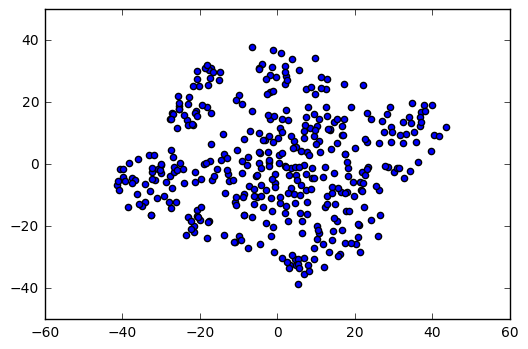

In [17]:
plt.scatter(two_d_embeddings[:,0], two_d_embeddings[:,1])
plt.show()


In [20]:
def clean_line(s):
    return bytes(s, 'utf-8').decode('utf-8','ignore')
clean_line(sampled_questions[4])
cleaned_questions = list(map(clean_line,sampled_questions))
cleaned_questions[1:5]

['What word is the word pharmacy taken from?',
 "What was Ghandi's work called?",
 'In what year did the Tenth Doctor appear in the Sarah Jane series?',
 'How else might a physician take advantage of self-interest?']

In [22]:
import mpld3
fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))

scatter = ax.scatter(two_d_embeddings[:,0], two_d_embeddings[:,1],
                     alpha=0.3,
                     cmap=plt.cm.jet)
ax.grid(color='white', linestyle='solid')

ax.set_title("DrQA Question Space", size=20)

tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=cleaned_questions)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()